In [ ]:
!nvidia-smi

Sat Dec 10 15:17:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    51W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# Download YOLOv7 repository and install requirements

%cd /content
!git clone https://github.com/WongKinYiu/yolov7.git
%cd yolov7
!pip install -r requirements.txt

/content
Cloning into 'yolov7'...
remote: Enumerating objects: 1094, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 1094 (delta 0), reused 1 (delta 0), pack-reused 1091
Receiving objects: 100% (1094/1094), 69.85 MiB | 46.03 MiB/s, done.
Resolving deltas: 100% (522/522), done.
/content/yolov7
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.1 MB/s 


In [ ]:
!sed -n -e 1557p -e 1404p /content/yolov7/utils/loss.py

            from_which_layer = from_which_layer[fg_mask_inboxes]
            from_which_layer = from_which_layer[fg_mask_inboxes]


第1557和第1404要修改 不然會Error

In [ ]:
# 注意跳脫自字元
!sed -i '1557s/from_which_layer\[fg_mask_inboxes\]/from_which_layer.to(fg_mask_inboxes.device)\[fg_mask_inboxes\]/' /content/yolov7/utils/loss.py
!sed -i '1404s/from_which_layer\[fg_mask_inboxes\]/from_which_layer.to(fg_mask_inboxes.device)\[fg_mask_inboxes\]/' /content/yolov7/utils/loss.py

!sed -n -e 1557p -e 1404p /content/yolov7/utils/loss.py

            from_which_layer = from_which_layer.to(fg_mask_inboxes.device)[fg_mask_inboxes]
            from_which_layer = from_which_layer.to(fg_mask_inboxes.device)[fg_mask_inboxes]


In [ ]:
import os
%cd /content/yolov7

'''
!gdown --id '1y4L4uB97FgVdFZyOw8NiGkVKKlnQHYsx'
!unzip -q mydataset1000.zip
os.remove("mydataset1000.zip")
'''

!cp '/gdrive/MyDrive/Alex_Lin/無人機比賽/mydataset1000.zip' '/content/yolov7/mydataset1000.zip'
!unzip -q 'mydataset1000.zip'
os.remove("mydataset1000.zip")

/content/yolov7


In [ ]:
yaml_file = "/content/yolov7/mydataset1000/data.yaml"
if os.path.exists(yaml_file) == False:
  f= open(yaml_file,"w+")
  f.write("train: /content/yolov7/mydataset1000/train/images\n") # train資料位置
  f.write("val: /content/yolov7/mydataset1000/val/images\n")
  f.write("nc: 4\n") # 修改:有幾個類別
  f.write("\n")
  # 自己dataset的類別
  f.write("names: ['car', 'hov', 'person', 'motorcycle']\n") # 修改
  f.close()


In [ ]:
!sed -n -e 8p -e 9p -e 10p -e 11p cfg/training/yolov7-w6.yaml

  - [ 19,27,  44,40,  38,94 ]  # P3/8
  - [ 96,68,  86,152,  180,137 ]  # P4/16
  - [ 140,301,  303,264,  238,542 ]  # P5/32
  - [ 436,615,  739,380,  925,792 ]  # P6/64


In [ ]:
!sed -i '8s/19,27,  44,40,  38,94/6,21,  13,14,  11,23/' cfg/training/yolov7-w6.yaml
!sed -i '9s/96,68,  86,152,  180,137/18,23,  13,34,  30,26/' cfg/training/yolov7-w6.yaml
!sed -i '10s/140,301,  303,264,  238,542/22,37,  17,53,  22,71/' cfg/training/yolov7-w6.yaml
!sed -i '11s/436,615,  739,380,  925,792/40,39,  37,67,  77,91/' cfg/training/yolov7-w6.yaml

!sed -n -e 8p -e 9p -e 10p -e 11p cfg/training/yolov7-w6.yaml

  - [ 6,21,  13,14,  11,23 ]  # P3/8
  - [ 18,23,  13,34,  30,26 ]  # P4/16
  - [ 22,37,  17,53,  22,71 ]  # P5/32
  - [ 40,39,  37,67,  77,91 ]  # P6/64


In [ ]:
%cd /content/yolov7
!pwd

/content/yolov7
/content/yolov7


下載前一階段在VisDrone訓練4類別的權重檔準備接類訓練

In [ ]:
''' gdown 常常很奇怪
!gdown --id '1sFRR7dgHlrt2ZMvF4Udecz2D4hTM95l2' --output data.zip
!unzip -q data.zip
os.remove("data.zip")
'''

!cp '/gdrive/MyDrive/Alex_Lin/無人機比賽/用到VisDrone/3_best.zip' '/content/yolov7/3_best.zip'
!unzip -q '3_best.zip'
os.remove("3_best.zip")

### 使用 wandb 記錄訓練過程
- 先官網登入：https://wandb.ai/site 
- 右上方頭像 -> settings -> 複製 API keys -> 填入下方輸入處

In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 5.1 MB/s 
     |████████████████████████████████| 182 kB 91.1 MB/s 
     |████████████████████████████████| 168 kB 86.8 MB/s 
     |████████████████████████████████| 62 kB 1.6 MB/s 
     |████████████████████████████████| 168 kB 97.1 MB/s 
     |████████████████████████████████| 166 kB 92.1 MB/s 
     |████████████████████████████████| 166 kB 99.8 MB/s 
     |████████████████████████████████| 162 kB 79.9 MB/s 
     |████████████████████████████████| 162 kB 72.5 MB/s 
     |████████████████████████████████| 158 kB 93.3 MB/s 
     |████████████████████████████████| 157 kB 101.0 MB/s 
     |████████████████████████████████| 157 kB 99.8 MB/s 
     |████████████████████████████████| 157 kB 78.5 MB/s 
     |████████████████████████████████| 157 kB 78.2 MB/s 
     |████████████████████████████████| 157 kB 75.0 MB/s 
     |███████████████████████████

In [ ]:
import wandb
# Logging
id = wandb.util.generate_id()
wandb_run = wandb.init()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
'''如果train.py那邊有error 又重新執行的話，最好在跑一次id
我本來看 id是 29mx03y8
但執行train.py時batch-size 8不能執行
我改成 batch-size 4 之後id好像有改
在wandb上看到變成 29mx03y82
'''
id 
# 把亂碼印出來 到wandb看結果時就找這組亂碼 是對到這次訓練

'j33oolsz'

### 開始訓練

In [ ]:
# 注意--data和--weights的路徑

!python train_aux.py --epochs 500 \
--batch-size 22 \
--data mydataset1000/data.yaml \
--img 1280 1280 \
--device 0 \
--cfg cfg/training/yolov7-w6.yaml \
--weights '3_best.pt' \
--hyp data/hyp.scratch.custom.yaml

YOLOR 🚀 v0.1-116-g8c0bf3f torch 1.13.0+cu116 CUDA:0 (A100-SXM4-40GB, 40536.1875MB)

Namespace(adam=False, artifact_alias='latest', batch_size=22, bbox_interval=-1, bucket='', cache_images=False, cfg='cfg/training/yolov7-w6.yaml', data='mydataset1000/data.yaml', device='0', entity=None, epochs=500, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.custom.yaml', image_weights=False, img_size=[1280, 1280], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/exp', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=22, upload_dataset=False, v5_metric=False, weights='3_best.pt', workers=8, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
2022-12-10 15:20:59.368368: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see sl

F1 and Precision Recall Curve

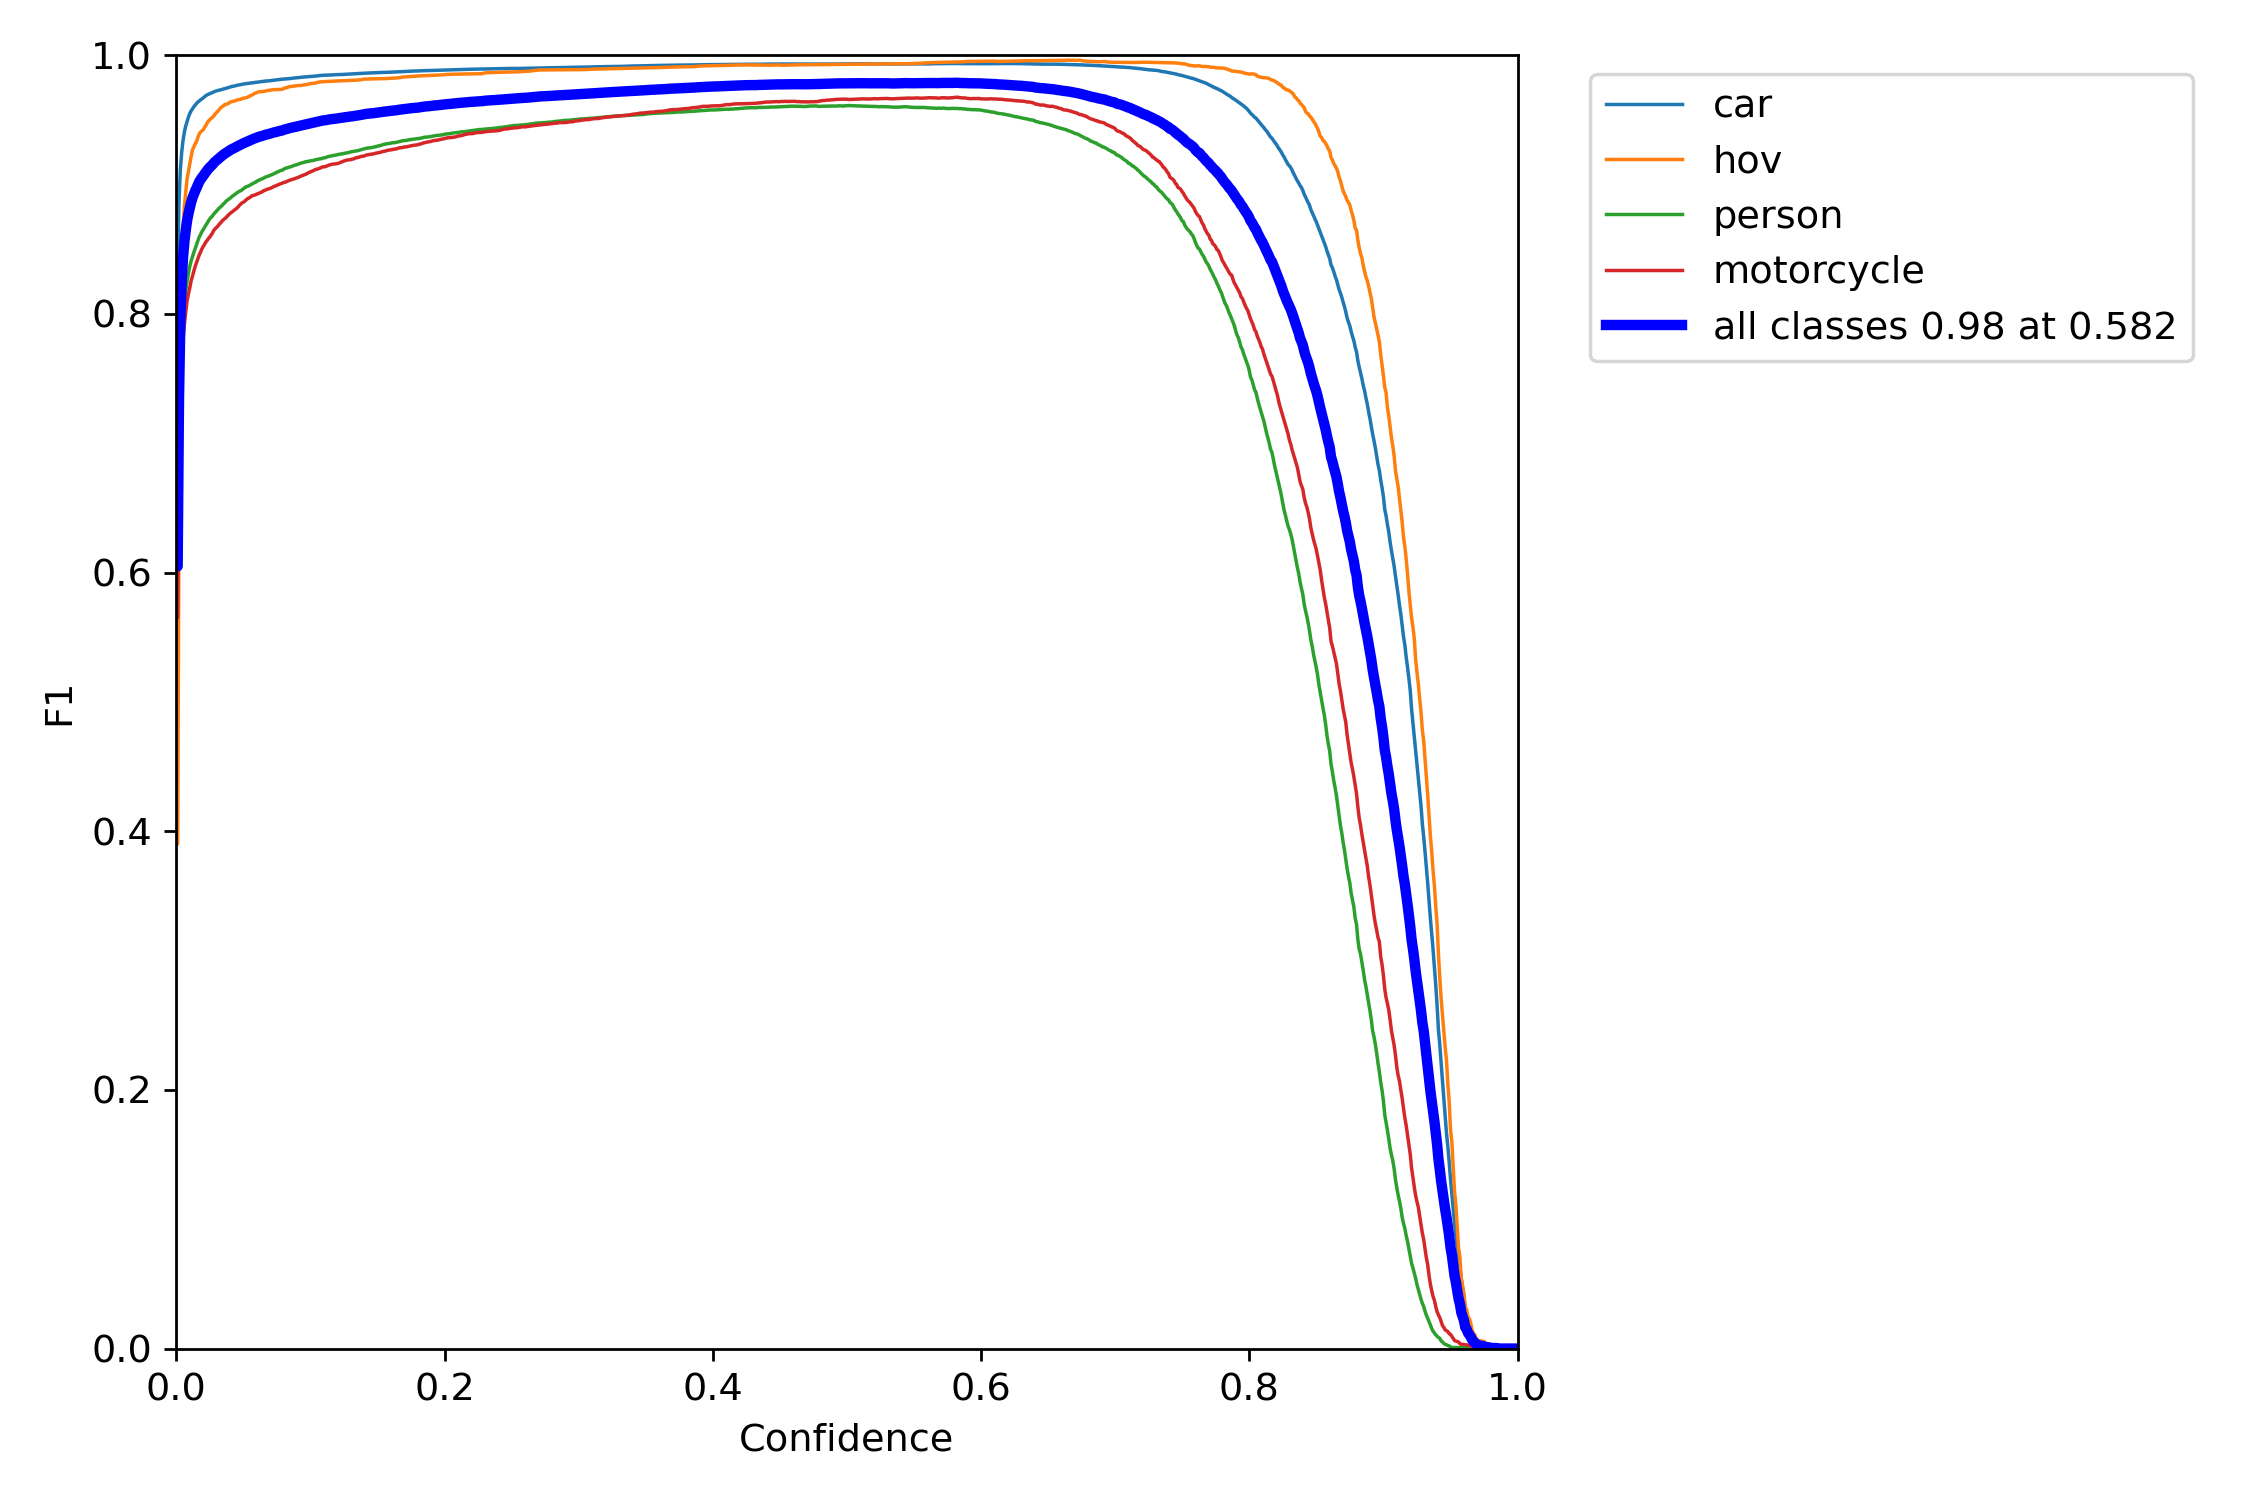

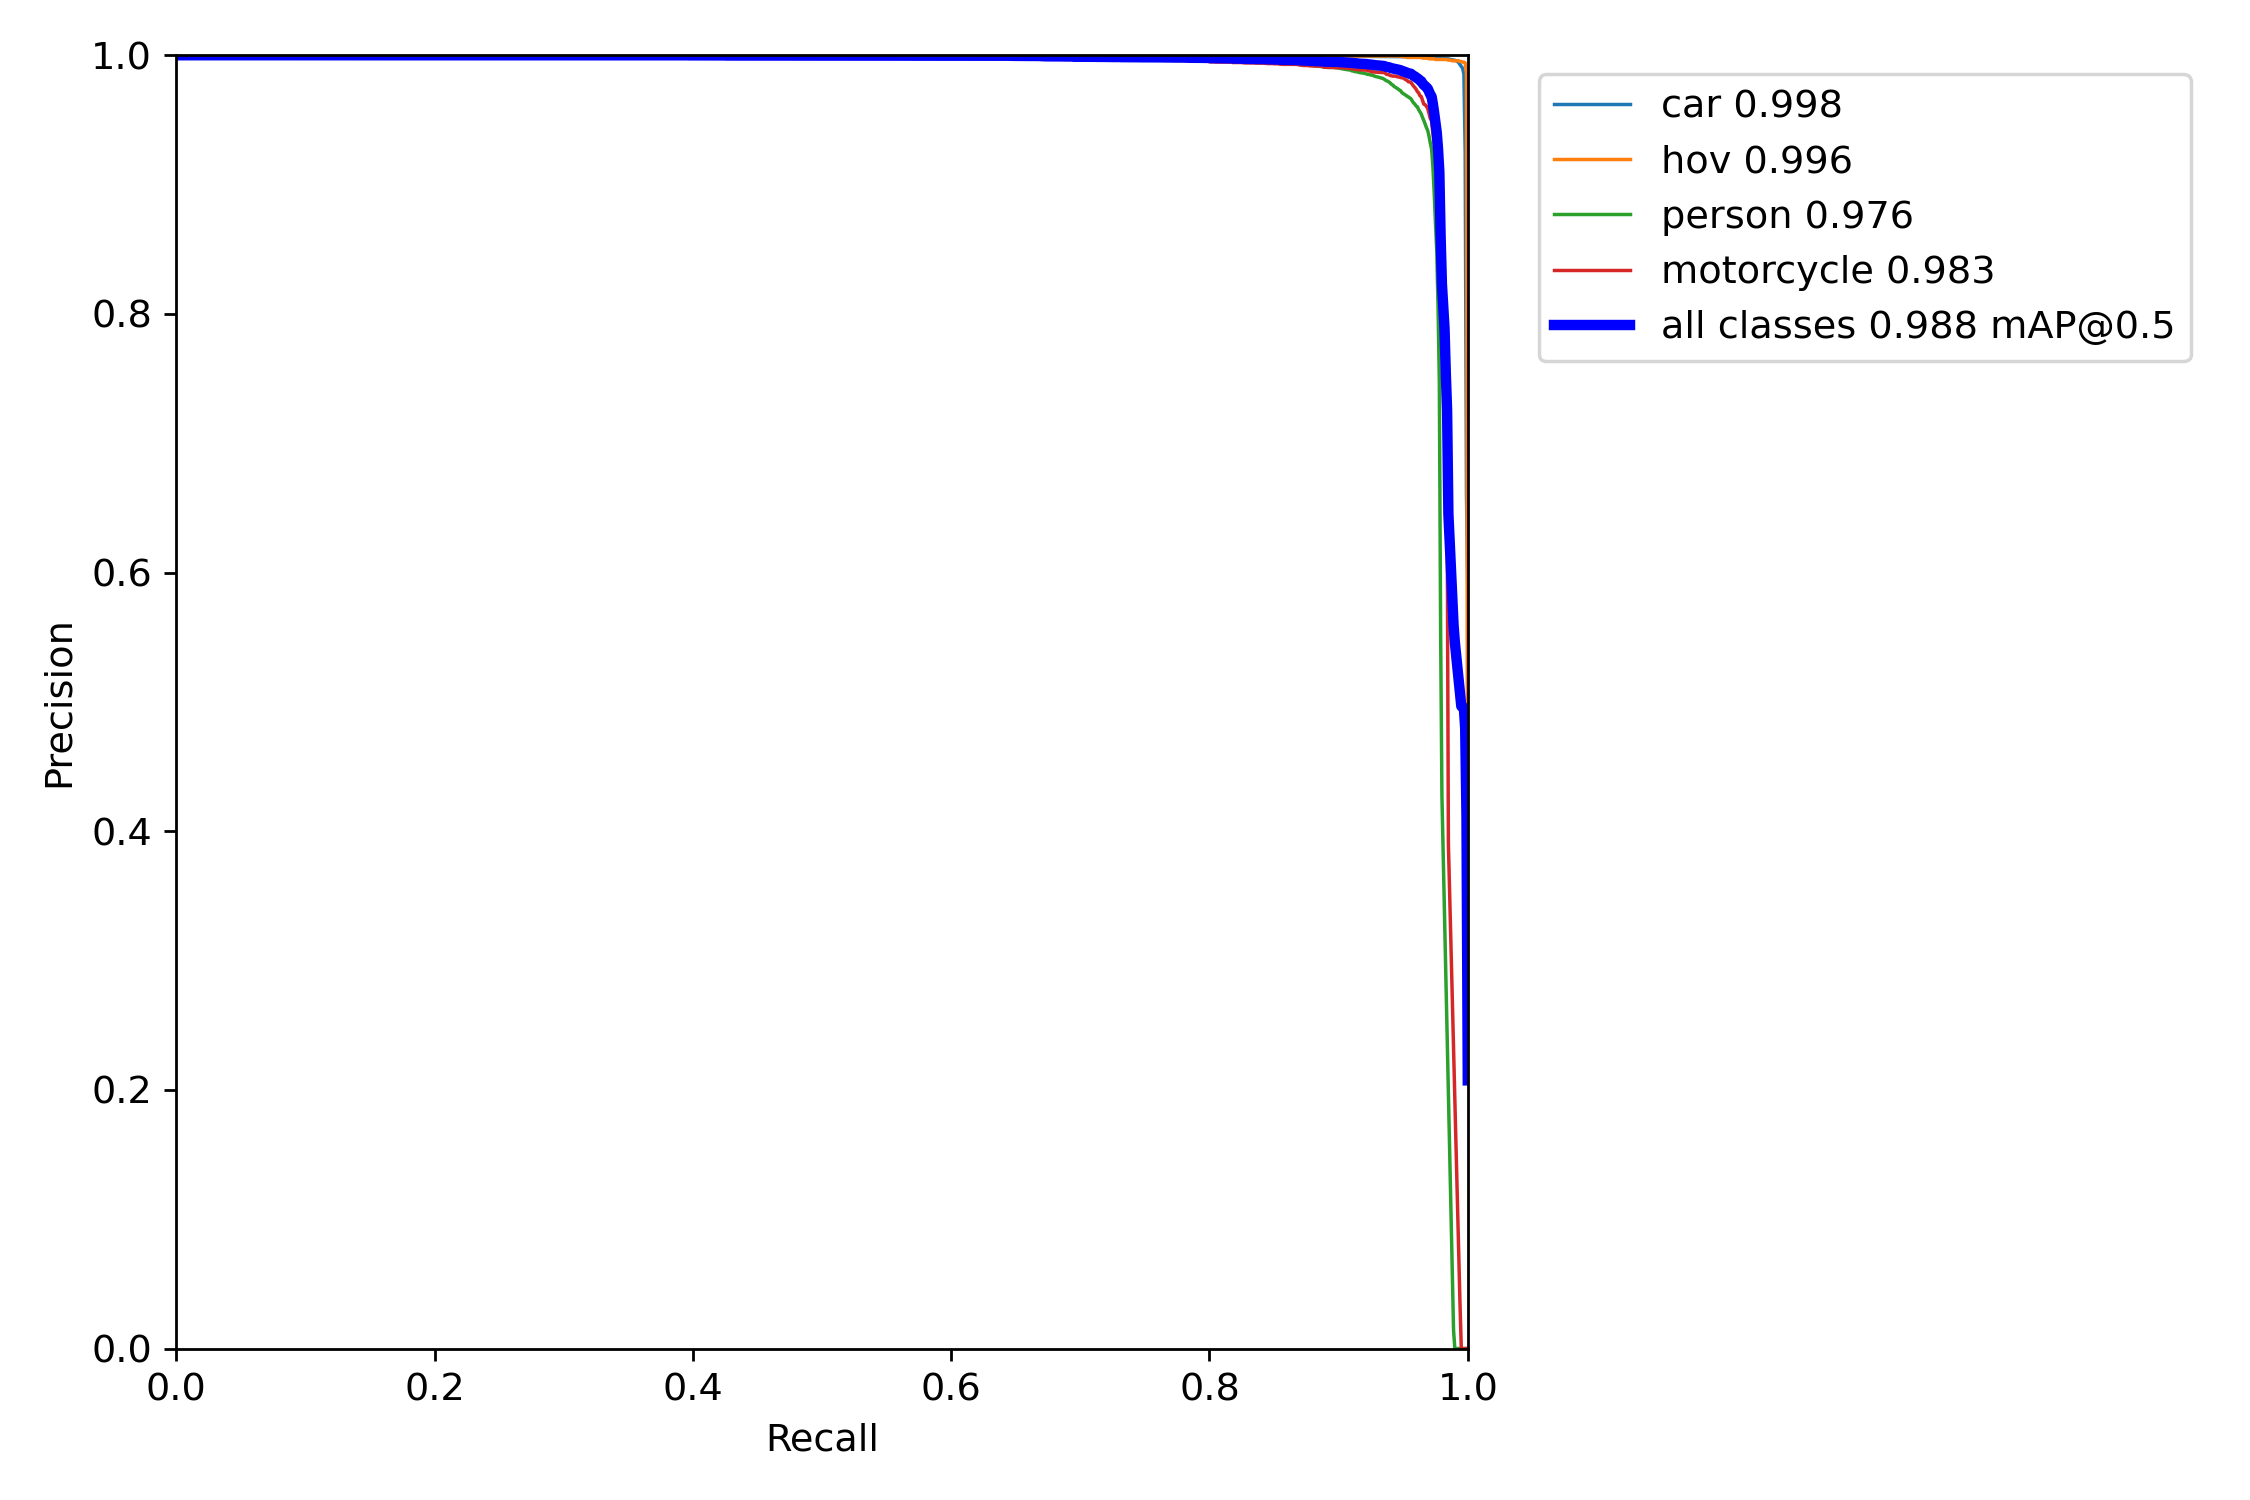

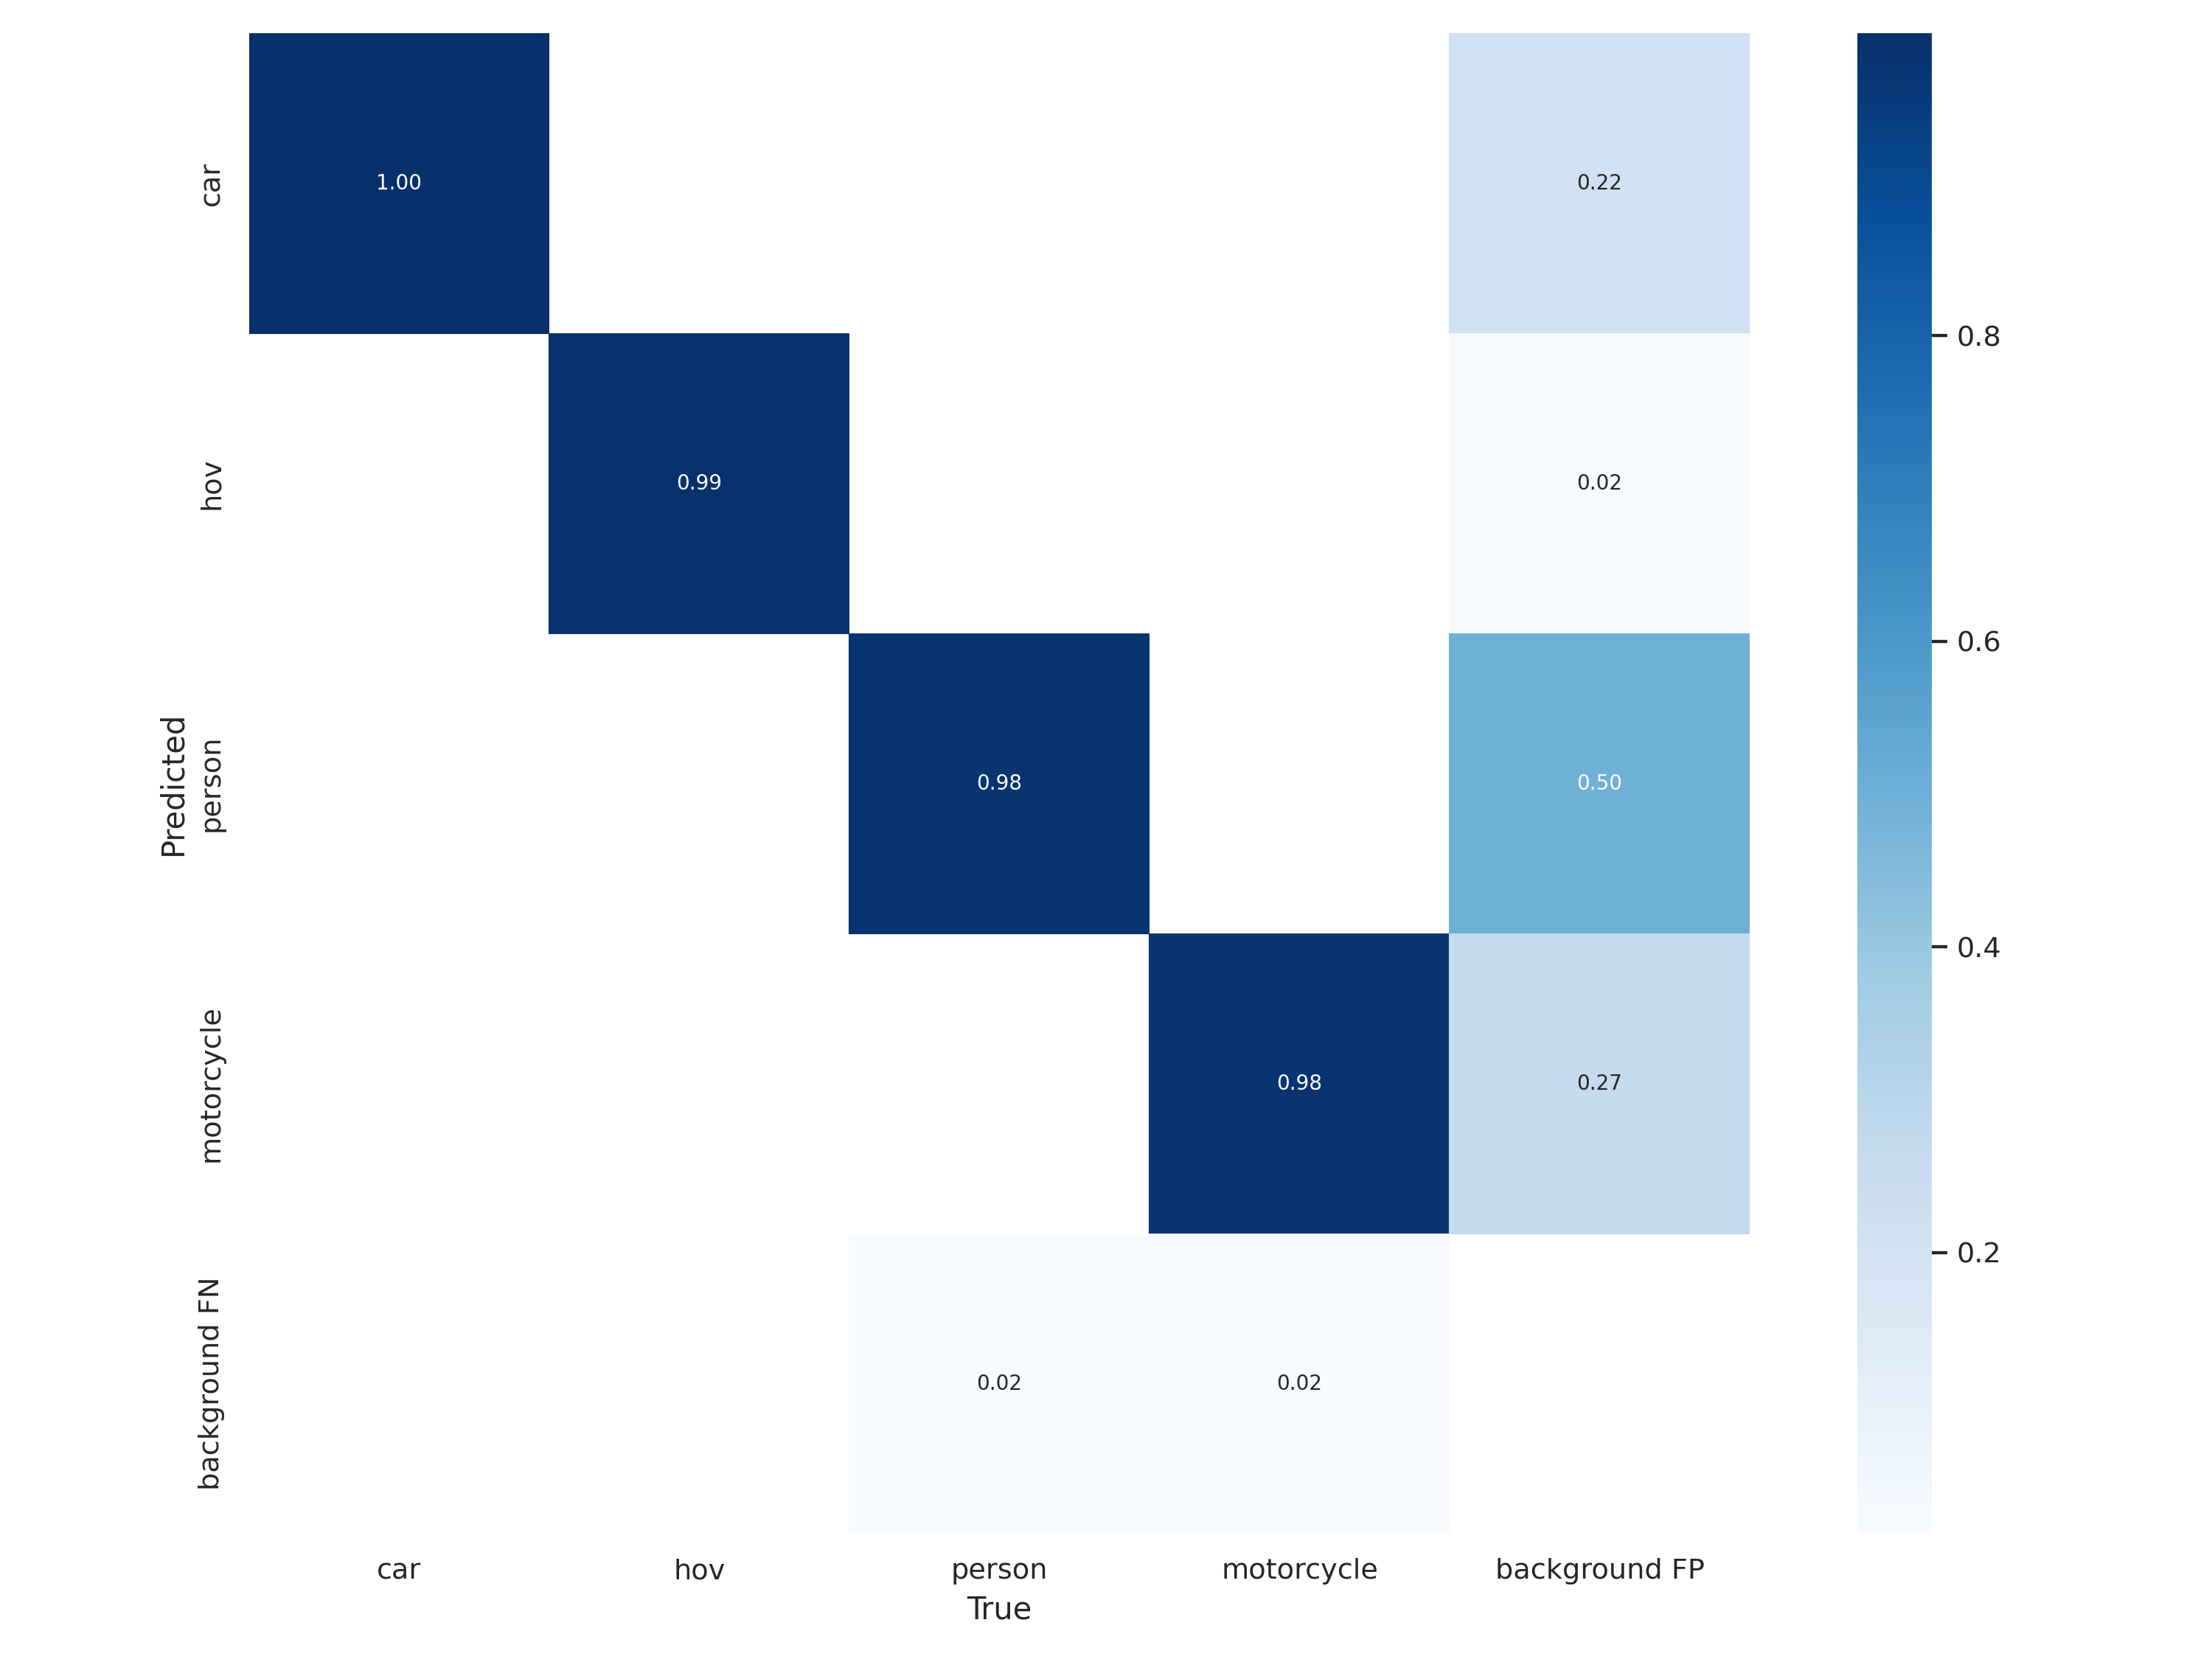

In [ ]:
from IPython.display import Image

chosen_folder= '/content/yolov7/runs/train/exp/'
display(Image(chosen_folder + "F1_curve.png", width=800, height=400))
display(Image(chosen_folder + "PR_curve.png", width=800, height=400))
display(Image(chosen_folder + "confusion_matrix.png", width=720, height=540))

準備做最終的推論

In [ ]:
import os
import sys
sys.path.append('/content/yolov7')

import argparse
import time
from pathlib import Path
import cv2
import torch
import numpy as np
import torch.backends.cudnn as cudnn
from numpy import random

from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
    scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path
from utils.plots import plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized, TracedModel


def letterbox(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)

注意weights和yaml檔位置，也可自行試試看不同的conf和IOU門檻值

In [ ]:
classes_to_filter = None  #You can give list of classes to filter by name, Be happy you don't have to put class number. ['train','person' ]


opt  = {
    # 修改:權重位置很重要 很重要 很重要，尤其要注意exp
    "weights": "runs/train/exp/weights/best.pt", # Path to weights file default weights are for nano model
    "yaml"   : "mydataset1000/data.yaml",
    "img-size": 1280, # default image size
    "conf-thres": 0.47, # confidence threshold for inference.
    "iou-thres" : 0.66, # NMS IoU threshold for inference.
    "device" : '0',  # device to run our model i.e. 0 or 0,1,2,3 or cpu
    "classes" : classes_to_filter  # list of classes to filter or None

}

In [ ]:
import cv2
import csv

def myinfer(source_image_path, csv_dir='/content/output_csv', image_dir='/content/output_images'): 
  
  with torch.no_grad():
    weights, imgsz = opt['weights'], opt['img-size']
    set_logging()
    device = select_device(opt['device'])
    half = device.type != 'cpu'
    model = attempt_load(weights, map_location=device)  # load FP32 model
    stride = int(model.stride.max())  # model stride
    imgsz = check_img_size(imgsz, s=stride)  # check img_size
    if half:
      model.half()

    names = model.module.names if hasattr(model, 'module') else model.names
    colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]
    if device.type != 'cpu':
      model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))

    img0 = cv2.imread(source_image_path)
    img = letterbox(img0, imgsz, stride=stride)[0]
    img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
    img = np.ascontiguousarray(img)
    img = torch.from_numpy(img).to(device)
    img = img.half() if half else img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    if img.ndimension() == 3:
      img = img.unsqueeze(0)

    # Inference
    t1 = time_synchronized()
    pred = model(img, augment= False)[0]

    # Apply NMS
    classes = None
    if opt['classes']:
      classes = []
      for class_name in opt['classes']:
        classes.append(opt['classes'].index(class_name))


    pred = non_max_suppression(pred, opt['conf-thres'], opt['iou-thres'], classes= classes, agnostic= False)
    t2 = time_synchronized()
    for i, det in enumerate(pred):
      s = ''
      s += '%gx%g ' % img.shape[2:]  # print string
      gn = torch.tensor(img0.shape)[[1, 0, 1, 0]]
      if len(det):
        det[:, :4] = scale_coords(img.shape[2:], det[:, :4], img0.shape).round()

        for c in det[:, -1].unique():
          n = (det[:, -1] == c).sum()  # detections per class
          s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string
      
        for *xyxy, conf, cls in reversed(det):

          label = f'{names[int(cls)]} {conf:.2f}'
          plot_one_box(xyxy, img0, label=label, color=colors[int(cls)], line_thickness=3)

  # 把推論圖片的結果用csv存下來
  name = source_image_path.split('/')[-1]
  img_name = name.split('.')[0]
  csv_name = csv_dir + '/' + name.split('.')[0] + ".csv"

  with open(csv_name, 'w', newline='') as csvfile:

    # 以空白分隔欄位，建立 CSV 檔寫入器
    writer = csv.writer(csvfile, delimiter=',') # 逗號分隔

    for i in pred[0].tolist():
      # i[0]左上x, i[1]左上y, i[2]右下x, i[3]右下y, i[4]信心, i[5]類別id      
      cls_id = int(i[5]) # 類別id
      bbox_LTx = int(np.round(i[0],0)) # 左上x
      bbox_LTy = int(np.round(i[1],0)) # 左上y
      bbox_W = int(np.round((i[2]-i[0]), 0)) # bbox寬
      bbox_H = int(np.round((i[3]-i[1]), 0)) # bbox高
      writer.writerow([img_name, cls_id, bbox_LTx, bbox_LTy, bbox_W, bbox_H ])
   
  output_path = image_dir  + '/' + name
  cv2.imwrite(output_path, img0)

### 上傳測試集

(1)上傳Public Testing

In [ ]:
'''
!gdown --id '1w8_OXLm3UvxNTYlliIvoz258iedpxH5-' --output data.zip
!unzip -q data.zip
os.remove("data.zip")
'''

!cp '/gdrive/MyDrive/Alex_Lin/無人機比賽/Public Testing Dataset_v2.zip' '/content/yolov7/Public Testing Dataset_v2.zip'
!unzip -q 'Public Testing Dataset_v2.zip'
os.remove("Public Testing Dataset_v2.zip")

執行myinfer之前先檢查output路徑有沒有準備空的資料夾去接

In [ ]:
import time
since = time.time() # 計時

# test圖片所在的資料夾
thepath = "/content/yolov7/public"

for image in os.listdir(thepath):
  #print(image)
  img_path = thepath + '/' + image
  myinfer(source_image_path=img_path, csv_dir='/content/public_csv', image_dir='/content/public_images')

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Fusing layers... 
IAuxDetect.fuse


/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers.

(2)上傳Private Testing

In [ ]:
'''
!gdown --id '1DyZpY2AqTzHOYNg2L5SfbIuHF5l70e1F' --output data.zip
!unzip -q data.zip
os.remove("data.zip")
'''

!cp '/gdrive/MyDrive/Alex_Lin/無人機比賽/Private Testing Dataset_v2.zip' '/content/yolov7/Private Testing Dataset_v2.zip'
!unzip -q 'Private Testing Dataset_v2.zip'
os.remove("Private Testing Dataset_v2.zip")

執行myinfer之前先檢查output路徑有沒有準備空的資料夾去接

In [ ]:
import time
since = time.time() # 計時

# test圖片所在的資料夾
thepath = "/content/yolov7/Private Testing Dataset_v2"

for image in os.listdir(thepath):
  #print(image)
  img_path = thepath + '/' + image
  myinfer(source_image_path=img_path, csv_dir='/content/Private_csv', image_dir='/content/Private_images')

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers... 
IAuxDetect.fuse
Fusing layers.

整理成比賽要上傳的格式

In [ ]:
import os
import pandas as pd
import numpy as np


def concatcsv(dir="/content/public_csv", output="/content/output.csv"):  
  end = pd.DataFrame()
  for i in os.listdir(dir):
    csv_path = dir + '/' + i
    df = pd.read_csv(csv_path, header=None)
    end = pd.concat([end,df],axis=0)

    end.to_csv(output, index=False, header=False)


def concatcsv2(public_path="/content/public.csv", Private_path="/content/Private.csv", output="/content/yolo.csv"):
  df1 = pd.read_csv(public_path, header=None)
  df2 = pd.read_csv(Private_path, header=None)
  end1 = pd.concat([df1,df2],axis=0)
  end1.to_csv(output, index=False, header=False)


In [ ]:
# 把所有public的預測結果合併成一個csv
concatcsv(dir="/content/public_csv", output="/content/public.csv")

In [ ]:
# 把所有Private的預測結果合併成一個csv
concatcsv(dir="/content/Private_csv", output="/content/Private.csv")

In [ ]:
# 把public和Private合併，變成比賽要我們上傳的樣子
concatcsv2(public_path="/content/public.csv", Private_path="/content/Private.csv", output="/content/4A_my1000_4766.csv")